In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import glob
import os

In [2]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'°C',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'°C', 
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'°C',
         'QGL': 'm³/s'}

var = ['Pressão na PDG (Medidor de fundo)',
         'Pressão no TPT (Transdutor de temp. e pressão)',
         'Temperatura no TPT (Transdutor de temp. e pressão)',
         'Pressão upstream na PCK (Válvula choke de produção)',
         'Temperatura downstream na PCK (Válvula choke de produção)',
         'Pressão downstream na GLCK (Gás lift)',
         'Temperatura downstream na GLCK (Gás lift)',
         'Vazão do Gas lift']

reference_table = pd.DataFrame(index=np.arange(1,len(var)+1))
reference_table.index.name='Variável'
reference_table['Tag'] = tags.keys()
reference_table['Nome'] = var
reference_table['Unidades'] = tags.values()
reference_table

,Tag,Nome,Unidades
Variável,,,
1,P-PDG,Pressão na PDG (Medidor de fundo),Pa
2,P-TPT,Pressão no TPT (Transdutor de temp. e pressão),Pa
3,T-TPT,Temperatura no TPT (Transdutor de temp. e pres...,°C
4,P-MON-CKP,Pressão upstream na PCK (Válvula choke de prod...,Pa
5,T-JUS-CKP,Temperatura downstream na PCK (Válvula choke d...,°C
6,P-JUS-CKGL,Pressão downstream na GLCK (Gás lift),Pa
7,T-JUS-CKGL,Temperatura downstream na GLCK (Gás lift),°C
8,QGL,Vazão do Gas lift,m³/s


In [3]:
%%time
EVENT = 8

PATH = f'/kaggle/input/3w-dataset/3W/{EVENT}/'

files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
files

dfs = {}

for file in files:
    
    dfs[file[:-4]] = pd.read_csv(f'{PATH}/{file}', index_col = 0,
                     parse_dates = True).rename_axis(None)

n_real = []
n_sim = []
    
for key in dfs.keys():
    if 'SIMULATED' in key:
        n_sim.append(int(key[13:15]))
        continue
    else:
        n_real.append(int(key[8:10]))

CPU times: user 3.25 s, sys: 668 ms, total: 3.91 s
Wall time: 8.2 s


In [4]:
%%time

n_instancia = 0
n_simulados = 0
n_reais = 0
dados_simulados = pd.DataFrame()
dados_reais = pd.DataFrame()


file_list = glob.glob(PATH + "/*.csv")
todos_dados = pd.DataFrame(pd.read_csv(file_list[0]))

for i in range(0,(len(file_list))):

  if 'SIMULATED' in file_list[i]:
    simulados = pd.read_table(file_list[i], sep = ',')
    df = pd.DataFrame(simulados)
    df['N_Simulacao'] = n_sim[n_simulados]
    dados_simulados = pd.concat([dados_simulados, df], axis = 0, ignore_index = True)
    #dados_simulados = pd.concat([dados_simulados, indice_sim], axis = 0, ignore_index = True)
    n_simulados +=1
  else:
    reais = pd.read_table(file_list[i], sep = ',')
    df = pd.DataFrame(reais)
    df['Inst_real'] = n_real[n_reais]
    dados_reais = pd.concat([dados_reais, df], axis = 0, ignore_index = True)
    n_reais += 1

  data = pd.read_table(file_list[i], sep = ',')
  df_ = pd.DataFrame(data)
  todos_dados = pd.concat([todos_dados, df_], axis = 0, ignore_index = True)
  n_instancia +=1

print("Número de instâncias:", n_instancia)
print("Número de instâncias simuladas:", n_simulados)
print("Número de instâncias reais:", n_reais)

Número de instâncias: 84
Número de instâncias simuladas: 81
Número de instâncias reais: 3
CPU times: user 10.7 s, sys: 2.66 s, total: 13.4 s
Wall time: 13.7 s


# Análise dos dados

### Interpolação dos dados faltantes

In [5]:
dados_reais.interpolate(method='pad', limit=30, axis = 0, inplace = True)

### Análise e tratamento de *outliers*

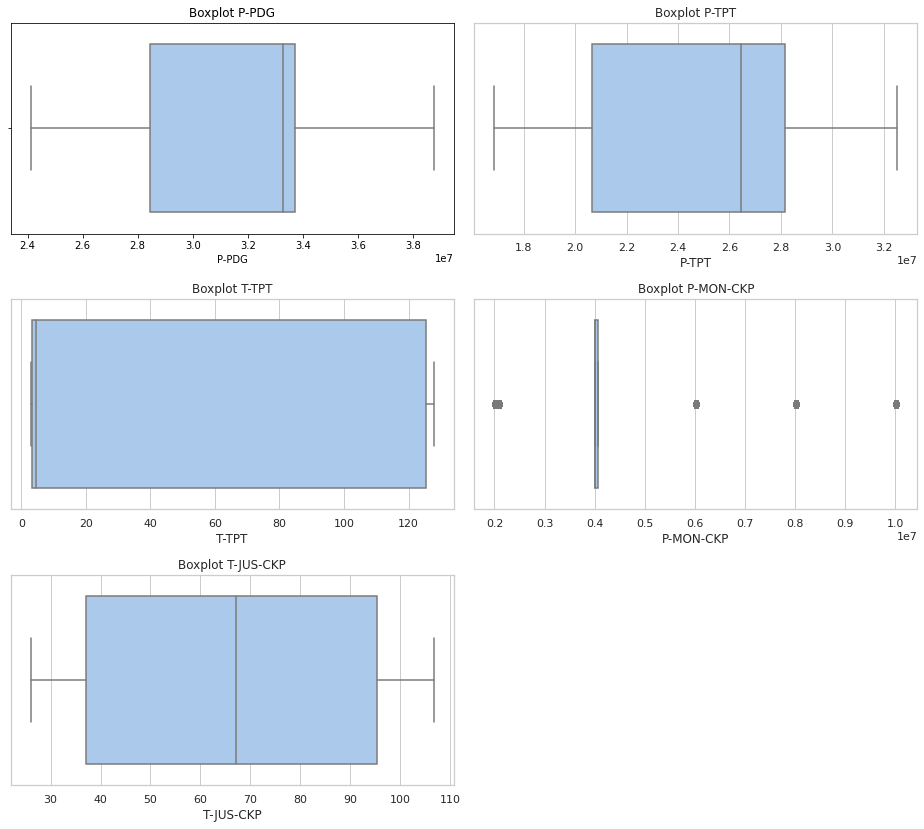

In [6]:
df_1 = dados_simulados[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']]
plt.figure(figsize=(13,15))

for i,cat in enumerate(df_1):
    plt.subplot(4,2,i+1)
    sns.set_theme(style="whitegrid", palette="pastel")
    sns.boxplot(x=cat, data=dados_simulados)
    plt.title("Boxplot {}".format(cat))
plt.tight_layout()
plt.show()

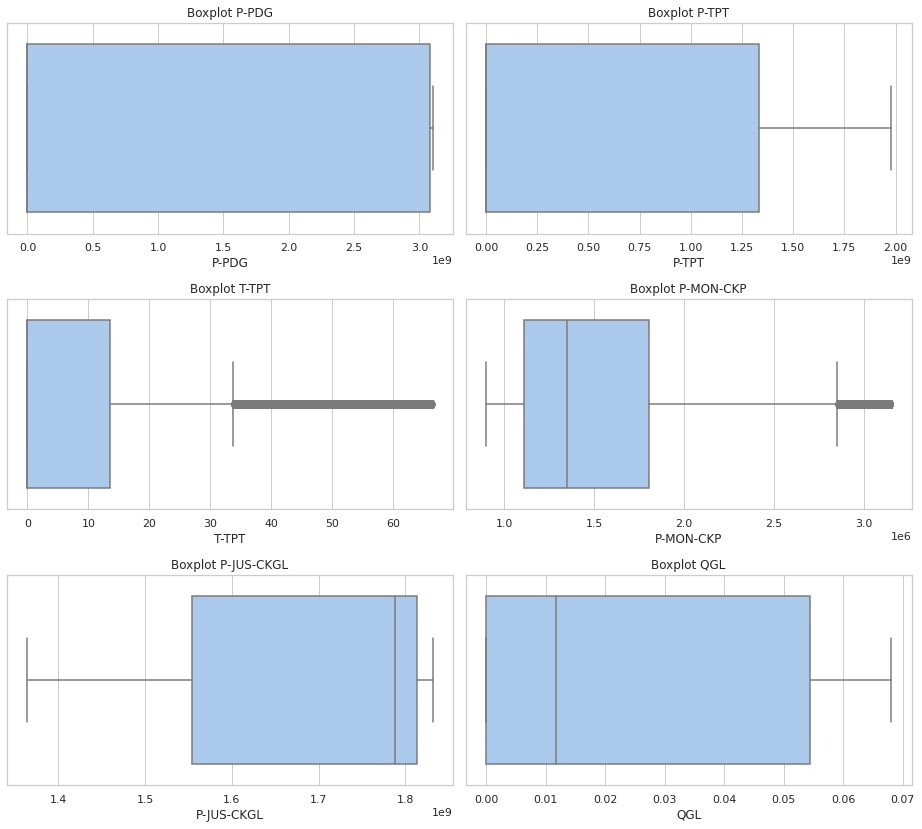

In [7]:
df_2 = dados_reais[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'P-JUS-CKGL','QGL']]
plt.figure(figsize=(13,15))

for i,cat in enumerate(df_2):
    plt.subplot(4,2,i+1)
    sns.set_theme(style="whitegrid", palette="pastel")
    sns.boxplot(x=cat, data=dados_reais)
    plt.title("Boxplot {}".format(cat))
plt.tight_layout()
plt.show()

In [8]:
from scipy import stats

z_scores1= stats.zscore(df_1)
z_scores1

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP
0,-0.997881,-1.475205,1.200606,-0.281959,1.397460
1,-0.997884,-1.475205,1.200606,-0.281959,1.397460
2,-0.997881,-1.475205,1.200606,-0.281959,1.397460
3,-0.997884,-1.475205,1.200606,-0.281959,1.397460
4,-0.997881,-1.475205,1.200606,-0.281959,1.397460
...,...,...,...,...,...
2186915,-0.093870,0.278250,-0.882796,-0.308915,-1.280758
2186916,-0.093160,0.278131,-0.882773,-0.308909,-1.281115
2186917,-0.092387,0.277605,-0.882669,-0.309152,-1.280783
2186918,-0.091749,0.277378,-0.882626,-0.309197,-1.279988


In [9]:
# Aplicaremos eliminação dos dados que obtiverem valores de z_scores > 3
abs_z_scores1 = abs(z_scores1)
filtered_entries = (abs_z_scores1 < 3).all(axis=1)
dados_simulados = dados_simulados[filtered_entries]
dados_simulados

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,N_Simulacao
0,2018-05-18 01:19:03.000000,28305440.0,18799850.0,127.376400,4047862.0,106.70890,NaN,NaN,NaN,0,4
1,2018-05-18 01:19:04.000000,28305430.0,18799850.0,127.376400,4047862.0,106.70890,NaN,NaN,NaN,0,4
2,2018-05-18 01:19:05.000000,28305440.0,18799850.0,127.376400,4047862.0,106.70890,NaN,NaN,NaN,0,4
3,2018-05-18 01:19:06.000000,28305430.0,18799850.0,127.376400,4047862.0,106.70890,NaN,NaN,NaN,0,4
4,2018-05-18 01:19:07.000000,28305440.0,18799850.0,127.376400,4047862.0,106.70890,NaN,NaN,NaN,0,4
...,...,...,...,...,...,...,...,...,...,...,...
2186915,2018-05-19 06:26:15.000000,31169200.0,25976770.0,3.429412,4002708.0,30.61968,NaN,NaN,NaN,8,25
2186916,2018-05-19 06:26:16.000000,31171450.0,25976280.0,3.430765,4002719.0,30.60952,NaN,NaN,NaN,8,25
2186917,2018-05-19 06:26:17.000000,31173900.0,25974130.0,3.436925,4002312.0,30.61897,NaN,NaN,NaN,8,25
2186918,2018-05-19 06:26:18.000000,31175920.0,25973200.0,3.439533,4002236.0,30.64154,NaN,NaN,NaN,8,25


In [10]:
z_scores2= stats.zscore(df_2)
z_scores2

,P-PDG,P-TPT,T-TPT,P-MON-CKP,P-JUS-CKGL,QGL
0,0.680342,0.083325,4.732996,-0.065027,-0.834462,1.270921
1,0.680357,0.083130,4.735381,-0.067530,-0.834352,1.271121
2,0.680371,0.082934,4.737766,-0.070033,-0.834242,1.271321
3,0.680385,0.082738,4.740151,-0.072538,-0.834132,1.271521
4,0.680400,0.082543,4.742537,-0.075041,-0.834023,1.271721
...,...,...,...,...,...,...
91086,-0.866127,-0.835377,-0.661243,-0.915145,0.838578,-0.933422
91087,-0.866127,-0.835377,-0.661243,-0.915077,0.838377,-0.933422
91088,-0.866127,-0.835377,-0.661243,-0.915009,0.838177,-0.933422
91089,-0.866127,-0.835377,-0.661243,-0.914942,0.837976,-0.933422


In [11]:
# Aplicaremos eliminação dos dados que obtiverem valores de z_scores > 3
abs_z_scores2 = abs(z_scores2)
filtered_entries = (abs_z_scores2 < 3).all(axis=1)
dados_reais = dados_reais[filtered_entries]
dados_reais

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,Inst_real
1845,2012-04-10 19:54:11.000000,2.193883e+09,1.131335e+09,40.19960,2333554.0,NaN,1.552505e+09,NaN,5.513926e-02,108.0,20
1846,2012-04-10 19:54:12.000000,2.193903e+09,1.131445e+09,40.17549,2336637.0,NaN,1.552529e+09,NaN,5.514189e-02,108.0,20
1847,2012-04-10 19:54:13.000000,2.193923e+09,1.131554e+09,40.15137,2339720.0,NaN,1.552553e+09,NaN,5.514453e-02,108.0,20
1848,2012-04-10 19:54:14.000000,2.193943e+09,1.131664e+09,40.12726,2342804.0,NaN,1.552577e+09,NaN,5.514716e-02,108.0,20
1849,2012-04-10 19:54:15.000000,2.193963e+09,1.131774e+09,40.10314,2345887.0,NaN,1.552601e+09,NaN,5.514980e-02,108.0,20
...,...,...,...,...,...,...,...,...,...,...,...
91086,2017-03-02 08:36:31.000000,0.000000e+00,0.000000e+00,0.00000,949673.2,NaN,1.810617e+09,NaN,3.738686e-22,8.0,19
91087,2017-03-02 08:36:32.000000,0.000000e+00,0.000000e+00,0.00000,949727.0,NaN,1.810586e+09,NaN,3.738686e-22,8.0,19
91088,2017-03-02 08:36:33.000000,0.000000e+00,0.000000e+00,0.00000,949780.8,NaN,1.810555e+09,NaN,3.738686e-22,8.0,19
91089,2017-03-02 08:36:34.000000,0.000000e+00,0.000000e+00,0.00000,949834.5,NaN,1.810524e+09,NaN,3.738686e-22,8.0,19


### Excluindo colunas com dados *NaN*

In [12]:
dados_simulados.drop(['timestamp', 'P-JUS-CKGL',	'T-JUS-CKGL',	'QGL'], axis=1, inplace=True)
dados_simulados.isna().sum()

P-PDG          0
P-TPT          0
T-TPT          0
P-MON-CKP      0
T-JUS-CKP      0
class          0
N_Simulacao    0
dtype: int64

In [13]:
dados_reais.drop(['timestamp', 'T-JUS-CKP', 'T-JUS-CKGL'], axis=1, inplace=True)
dados_reais.dropna()
dados_reais.isna().sum()

P-PDG           0
P-TPT           0
T-TPT           0
P-MON-CKP       0
P-JUS-CKGL      0
QGL             0
class         193
Inst_real       0
dtype: int64

# Preparando dados para treinamento dos modelos

Utilizaremos apenas os dados SIMULADOS para construção dos modelos

### Separando banco de dados para treinamento e teste

In [14]:
X = dados_simulados.iloc[:,:-2]
y = dados_simulados.iloc[:,-2]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

### Padronização dos dados

In [16]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

### Reduzindo a dimensionalidade dos dados utilizando a técnica de PCA (*Principal Component Analysis*)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X_train)
pca.fit(X_test)

PCA(n_components=2)

In [18]:
print("Componentes principais:")
print(pca.components_)

print("\nVariâncias explicadas:")
print(pca.explained_variance_)

Componentes principais:
[[ 0.49045958  0.5177313  -0.50751105  0.00896792 -0.483483  ]
 [ 0.01111549  0.00466542  0.03624945  0.9992648  -0.00324425]]

Variâncias explicadas:
[3.55252635 1.00099388]


Percebe-se que o primeiro componente principal consegue explicar uma parcela muito maior da variância dos dados do que o segundo componente principal.

In [19]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [20]:
X_train.shape

(1455246, 2)

In [21]:
X_test.shape

(623678, 2)

# Desenvolvimento dos modelos

### Modelo de Florestas Aleatórias

In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier
classificador = RandomForestClassifier(n_estimators = 50, criterion= 'entropy', random_state = 42)
classificador.fit(X_train, y_train)

CPU times: user 2min 46s, sys: 315 ms, total: 2min 47s
Wall time: 2min 48s


RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=42)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classificador.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 13978      0  27785]
 [     0  76958  95163]
 [  5577   5907 398310]]


Matriz de confusão sem normalização
[[ 13978      0  27785]
 [     0  76958  95163]
 [  5577   5907 398310]]
Matriz de confusão normalizada
[[0.33469818 0.         0.66530182]
 [0.         0.44711569 0.55288431]
 [0.01360928 0.01441456 0.97197616]]


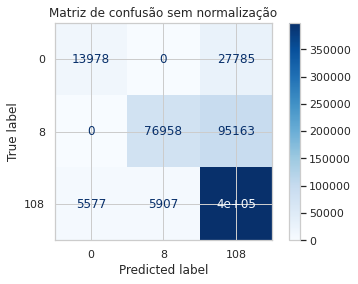

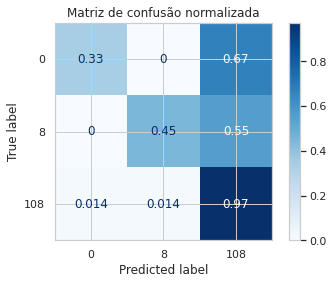

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

titles_options = [
    ("Matriz de confusão sem normalização", None),
    ("Matriz de confusão normalizada", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classificador,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [25]:
# Metricas de classificação
# =========================
from sklearn import metrics

print('\nRelatório das métricas de classificação para dados de teste:\n')
print(metrics.classification_report(y_test, y_pred))


Relatório das métricas de classificação para dados de teste:

              precision    recall  f1-score   support

           0       0.71      0.33      0.46     41763
           8       0.93      0.45      0.60    172121
         108       0.76      0.97      0.86    409794

    accuracy                           0.78    623678
   macro avg       0.80      0.58      0.64    623678
weighted avg       0.81      0.78      0.76    623678



### Redes Neurais Artificiais

In [26]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1,1)

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y_train = np.array(ct.fit_transform(y_train))
y_test = np.array(ct.fit_transform(y_test))
print(y_train)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid, softmax


tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        tf.keras.Input(shape=(2,)),
        Dense(25, activation = 'relu', name = "L1"),
        Dense(20, activation = 'relu', name = "L2"),
        Dense(3, activation = 'softmax', name = "L3"),    
    ], name = "my_model" 
)

2022-12-20 19:13:20.208221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 19:13:20.209214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 19:13:20.578612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 19:13:20.579611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 19:13:20.580476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [29]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 25)                75        
_________________________________________________________________
L2 (Dense)                   (None, 20)                520       
_________________________________________________________________
L3 (Dense)                   (None, 3)                 63        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


In [30]:
[layer1, layer2, layer3] = model.layers
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (2, 25), b1 shape = (25,)
W2 shape = (25, 20), b2 shape = (20,)
W3 shape = (20, 3), b3 shape = (3,)


In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%%time
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy']
    )

history = model.fit(X_train, y_train, epochs= 20,  validation_split = 0.5)

UsageError: Line magic function `%%time` not found.


In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
y_pred_ = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    y_pred_[i] = np.argmax(y_pred[i])
    
y_pred_

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y_pred_ = np.array(ct.fit_transform(y_pred_.reshape(-1, 1)))
print(y_pred_)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_.argmax(axis=1))
print(cm)
accuracy_score(y_test.argmax(axis=1), y_pred_.argmax(axis=1))

In [ ]:
# Metricas de classificação
# =========================
from sklearn import metrics

print('\nRelatório das métricas de classificação para dados de teste:\n')
print(metrics.classification_report(y_test.argmax(axis=1), y_pred_.argmax(axis=1)))